In [9]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uuid               3200 non-null   object
 1   postId             3200 non-null   object
 2   postText           3200 non-null   object
 3   postPlatform       3200 non-null   object
 4   targetParagraphs   3200 non-null   object
 5   targetTitle        3200 non-null   object
 6   targetDescription  2933 non-null   object
 7   targetKeywords     2116 non-null   object
 8   targetMedia        2685 non-null   object
 9   targetUrl          2717 non-null   object
 10  provenance         3200 non-null   object
 11  spoiler            3200 non-null   object
 12  spoilerPositions   3200 non-null   object
 13  tags               3200 non-null   object
dtypes: object(14)
memory usage: 350.1+ KB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 en

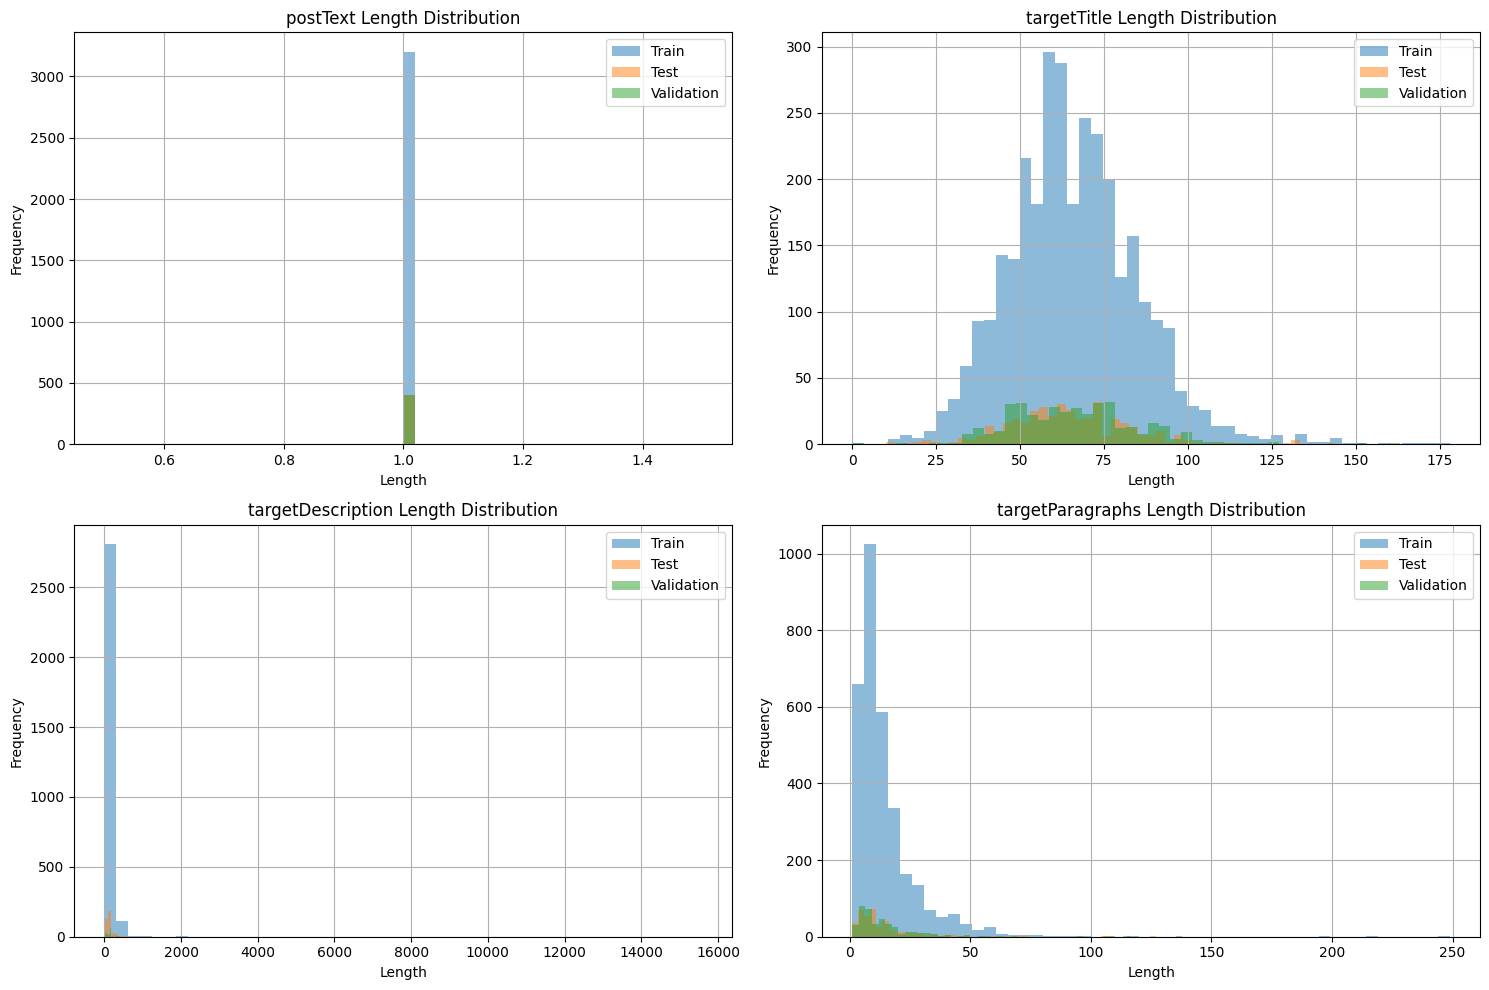

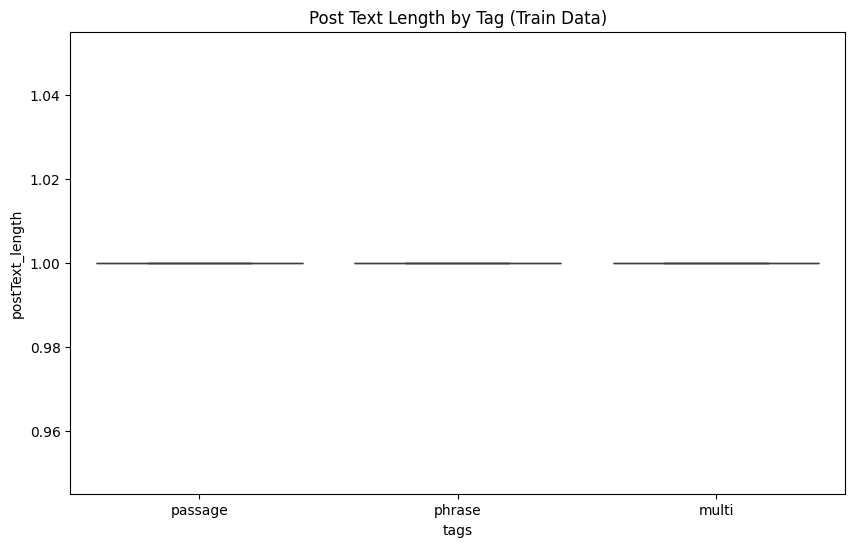

In [41]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train = pd.read_json('Dataset/train.jsonl', lines=True)
test = pd.read_json('Dataset/test.jsonl', lines=True)
val = pd.read_json('Dataset/val.jsonl', lines=True)

# Explore the datasets
print("Training Data Info:")
print(train.info())
print("\nTest Data Info:")
print(test.info())
print("\nValidation Data Info:")
print(val.info())

print("\nMissing values in Training Data:")
print(train.isnull().sum())
print("\nMissing values in Test Data:")
print(test.isnull().sum())
print("\nMissing values in Validation Data:")
print(val.isnull().sum())

# Analyze object columns
def analyze_object_columns(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            print(f"\nUnique values in {column}:")
            print(df[column].value_counts().head())

analyze_object_columns(train)
analyze_object_columns(test)
analyze_object_columns(val)

# Handle missing values
print("\nHandling missing values...")
imputer = SimpleImputer(strategy='constant', fill_value='')
for col in ['targetKeywords', 'targetMedia', 'targetUrl']:
    train[col] = imputer.fit_transform(train[[col]]).ravel()
    test[col] = imputer.transform(test[[col]]).ravel()
    val[col] = imputer.transform(val[[col]]).ravel()

# Create combined text columns
train['combined_text'] = train['postText'].astype(str) + ' ' + train['targetTitle'].astype(str) + ' ' + train['targetDescription'].astype(str)
test['combined_text'] = test['postText'].astype(str) + ' ' + test['targetTitle'].astype(str) + ' ' + test['targetDescription'].astype(str)
val['combined_text'] = val['postText'].astype(str) + ' ' + val['targetTitle'].astype(str) + ' ' + val['targetDescription'].astype(str)

# Verify the creation of 'combined_text'
print("\nTrain Columns After Combining Text:")
print(train.columns)
print("\nTest Columns After Combining Text:")
print(test.columns)
print("\nValidation Columns After Combining Text:")
print(val.columns)

# Handle missing values in combined text
train['combined_text'] = train['combined_text'].fillna('')
test['combined_text'] = test['combined_text'].fillna('')
val['combined_text'] = val['combined_text'].fillna('')

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_text = vectorizer.fit_transform(train['combined_text'])
X_test_text = vectorizer.transform(test['combined_text'])
X_val_text = vectorizer.transform(val['combined_text'])

# Convert to DataFrame for easier manipulation
X_train_text_df = pd.DataFrame(X_train_text.toarray(), columns=vectorizer.get_feature_names_out())
X_test_text_df = pd.DataFrame(X_test_text.toarray(), columns=vectorizer.get_feature_names_out())
X_val_text_df = pd.DataFrame(X_val_text.toarray(), columns=vectorizer.get_feature_names_out())

# Create length-based features
train['text_length'] = train['combined_text'].str.len()
test['text_length'] = test['combined_text'].str.len()
val['text_length'] = val['combined_text'].str.len()

# Add length-based features
X_train = pd.concat([X_train_text_df, train[['text_length']].reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_text_df, test[['text_length']].reset_index(drop=True)], axis=1)
X_val = pd.concat([X_val_text_df, val[['text_length']].reset_index(drop=True)], axis=1)

# Prepare the target variable
if 'tags' in train.columns:
    # Flatten lists in 'tags' column (if necessary)
    train['tags'] = train['tags'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)
    
    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(train['tags'])
    
    # Split the data
    X_train, X_val_split, y_train, y_val_split = train_test_split(X_train, y, test_size=0.2, random_state=42)
    
    print("Final training set shape:", X_train.shape)
    print("Final validation set shape:", X_val_split.shape)
    print("Final test set shape:", X_test.shape)
else:
    print("Error: 'tags' column not found in training data. Please check your data.")

# Plot text length distributions
text_columns = ['postText', 'targetTitle', 'targetDescription', 'targetParagraphs']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, column in enumerate(text_columns):
    if column in train.columns:
        train[column].str.len().hist(ax=axes[i//2, i%2], bins=50, alpha=0.5, label='Train')
        test[column].str.len().hist(ax=axes[i//2, i%2], bins=50, alpha=0.5, label='Test')
        val[column].str.len().hist(ax=axes[i//2, i%2], bins=50, alpha=0.5, label='Validation')
        axes[i//2, i%2].set_title(f'{column} Length Distribution')
        axes[i//2, i%2].set_xlabel('Length')
        axes[i//2, i%2].set_ylabel('Frequency')
        axes[i//2, i%2].legend()
plt.tight_layout()
plt.show()

# Relationship between text length and tags (only for train dataset)
if 'tags' in train.columns:
    train['postText_length'] = train['postText'].str.len()
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='tags', y='postText_length', data=train)
    plt.title('Post Text Length by Tag (Train Data)')
    plt.show()


In [ ]:
print(train['tags'].head())
# Flatten the lists of tags
flattened_tags = train['tags'].apply(lambda x: x if isinstance(x, str) else ','.join(x))

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the flattened tags
y = le.fit_transform(flattened_tags)


In [46]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the datasets
train = pd.read_json('Dataset/train.jsonl', lines=True)

# Combine text columns
train['combined_text'] = train['postText'].astype(str) + ' ' + train['targetTitle'].astype(str) + ' ' + train['targetDescription'].astype(str)

# Vectorize text data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_text = vectorizer.fit_transform(train['combined_text'])
X_train_text_df = pd.DataFrame(X_train_text.toarray(), columns=vectorizer.get_feature_names_out())

# Create length-based features
train['text_length'] = train['combined_text'].str.len()
X_train = pd.concat([X_train_text_df, train[['text_length']].reset_index(drop=True)], axis=1)

# Flatten the lists of tags if necessary
flattened_tags = train['tags'].apply(lambda x: x if isinstance(x, str) else ','.join(x))

# Prepare the target variable
le = LabelEncoder()
y = le.fit_transform(flattened_tags)

# Ensure consistent lengths
assert X_train.shape[0] == len(y), "Feature matrix and target variable have different lengths."
min_length = min(X_train.shape[0], len(y))
X_train = X_train.iloc[:min_length]
y = y[:min_length]

# Split the data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train_split.shape)
print("Validation set shape:", X_val_split.shape)


Training set shape: (2560, 5001)
Validation set shape: (640, 5001)


In [11]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from textblob import TextBlob
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# Load the datasets
train = pd.read_json('Dataset/train.jsonl', lines=True)
test = pd.read_json('Dataset/test.jsonl', lines=True)
val = pd.read_json('Dataset/val.jsonl', lines=True)

# Text cleaning function
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(map(str, text))
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text

# Sentiment analysis function
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Text augmentation function
def synonym_replacement(text):
    words = text.split()
    new_words = words.copy()
    for i in range(len(words)):
        synonyms = wordnet.synsets(words[i])
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words[i] = synonym
    return ' '.join(new_words)

# Preprocess and feature engineering
def preprocess_data(df):
    df['combined_text'] = df['postText'].astype(str) + ' ' + df['targetTitle'].astype(str) + ' ' + df['targetDescription'].astype(str)
    df['combined_text'] = df['combined_text'].apply(clean_text)
    df['text_length'] = df['combined_text'].str.len()
    df['sentiment'] = df['combined_text'].apply(get_sentiment)
    return df

# Apply preprocessing to all datasets
train = preprocess_data(train)
test = preprocess_data(test)
val = preprocess_data(val)

# Augment training data
train['augmented_text'] = train['combined_text'].apply(synonym_replacement)
train['combined_text'] = train['combined_text'] + ' ' + train['augmented_text']

# Tokenization and padding
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train['combined_text'])

def tokenize_and_pad(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_len)

X_train_text = tokenize_and_pad(train['combined_text'])
X_test_text = tokenize_and_pad(test['combined_text'])
X_val_text = tokenize_and_pad(val['combined_text'])

# One-hot encoding for categorical features
train_platform = pd.get_dummies(train['postPlatform'], prefix='platform')
test_platform = pd.get_dummies(test['postPlatform'], prefix='platform')
val_platform = pd.get_dummies(val['postPlatform'], prefix='platform')

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['text_length', 'sentiment']

X_train_numerical = scaler.fit_transform(train[numerical_features])
X_test_numerical = scaler.transform(test[numerical_features])
X_val_numerical = scaler.transform(val[numerical_features])

# Combine features
X_train = np.concatenate([X_train_text, X_train_numerical, train_platform.values], axis=1)
X_test = np.concatenate([X_test_text, X_test_numerical, test_platform.values], axis=1)
X_val = np.concatenate([X_val_text, X_val_numerical, val_platform.values], axis=1)

# Prepare target variable
train['tags'] = train['tags'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)
val['tags'] = val['tags'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)

le = LabelEncoder()
y_train = le.fit_transform(train['tags'])
y_val = le.transform(val['tags'])

# Convert to categorical for multi-class classification
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Final split
X_train, X_val_split, y_train_cat, y_val_split_cat = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)

print("Final training set shape:", X_train.shape)
print("Final validation set shape:", X_val_split.shape)
print("Final test set shape:", X_test.shape)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abiwaqasyasir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/abiwaqasyasir/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/abiwaqasyasir/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Final training set shape: (2560, 205)
Final validation set shape: (640, 205)
Final test set shape: (400, 205)


Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.3316 - loss: 1.1220 - val_accuracy: 0.4875 - val_loss: 1.0575
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.4032 - loss: 1.0727 - val_accuracy: 0.3938 - val_loss: 1.0635
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.4164 - loss: 1.0577 - val_accuracy: 0.5391 - val_loss: 0.9840
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.4784 - loss: 1.0037 - val_accuracy: 0.5547 - val_loss: 0.9664
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5153 - loss: 0.9396 - val_accuracy: 0.5437 - val_loss: 0.9497
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.5564 - loss: 0.9033 - val_accuracy: 0.5297 - val_loss: 0.9397
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.5863 - loss: 0.8332 - val_accuracy: 0.5672 - val_loss: 0.9180
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.6592 - loss: 0.7550 - val_accuracy: 0.5594 - val_loss: 0.

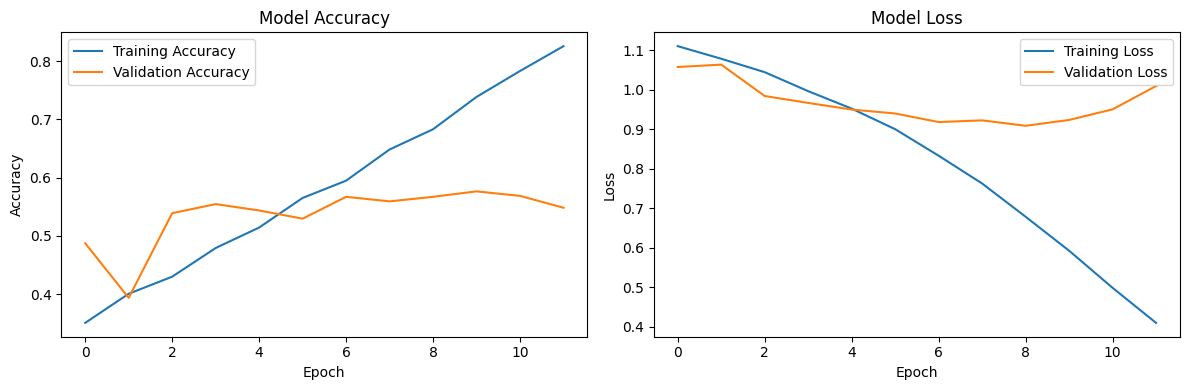

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Optional: Prepare embedding matrix (if using pre-trained embeddings)
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

# Load pre-trained embeddings (example using GloVe)
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build the neural network model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val_split, y_val_split_cat),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split_cat)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Make predictions on the test set
predictions = model.predict(X_test)

# Optional: Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3403 - loss: 1.1217 - val_accuracy: 0.2969 - val_loss: 1.1059 - learning_rate: 0.0010
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.3661 - loss: 1.0863 - val_accuracy: 0.4594 - val_loss: 1.0611 - learning_rate: 0.0010
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.4354 - loss: 1.0355 - val_accuracy: 0.4672 - val_loss: 1.0304 - learning_rate: 0.0010
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.4814 - loss: 0.9892 - val_accuracy: 0.4656 - val_loss: 1.0205 - learning_rate: 0.0010
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.5334 - loss: 0.9270 - val_accuracy: 0.4297 - val_loss: 1.0636 - learning_rate: 0.0010
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.5484 - loss: 0.8878 - val_accuracy: 0.5500 - val_loss: 0.9435 - learning_rate: 0.0010
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.6207 - loss: 0.8056 - val_accuracy: 0.52

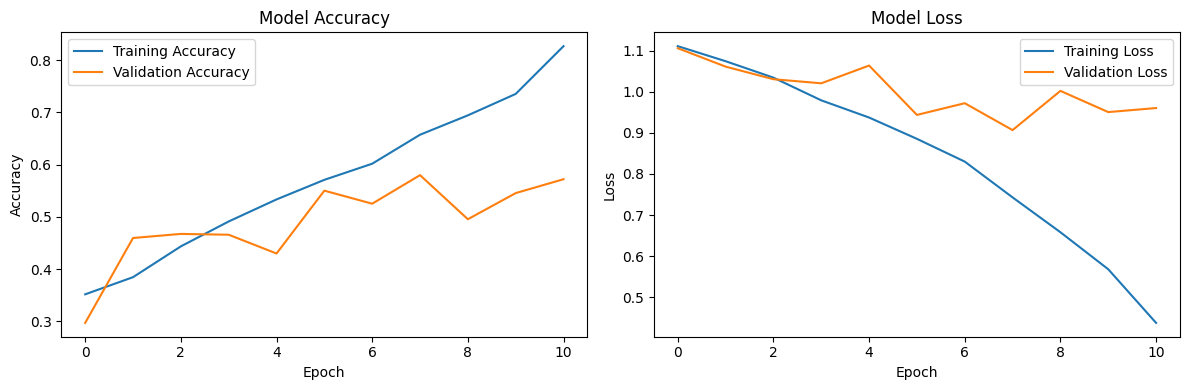

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPool1D, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure you have the GloVe embeddings downloaded and use them
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

# Load pre-trained embeddings (example using GloVe)
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    for word, i in tokenizer.word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
except FileNotFoundError:
    print("GloVe embeddings file not found. Using random embeddings.")

# Build the neural network model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val_split, y_val_split_cat),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split_cat)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Make predictions on the test set
predictions = model.predict(X_test)

# Optional: Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Fold 1/5
Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.4112 - loss: 1.0532 - val_accuracy: 0.4375 - val_loss: 1.0426 - learning_rate: 0.0010
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.4319 - loss: 1.0256 - val_accuracy: 0.4414 - val_loss: 1.0347 - learning_rate: 0.0010
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - accuracy: 0.4315 - loss: 1.0261 - val_accuracy: 0.4355 - val_loss: 1.0545 - learning_rate: 0.0010
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.4585 - loss: 1.0108 - val_accuracy: 0.4180 - val_loss: 1.0259 - learning_rate: 0.0010
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.4788 - loss: 0.9860 - val_accuracy: 0.4258 - val_loss: 1.0495 - learning_rate: 0.0010
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step - accuracy: 0.5099 - loss: 0.9761 - val_accuracy: 0.4238 - val_loss: 1.0532 - learning_rate: 0.0010
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 258ms/step - accuracy: 0.5600 -

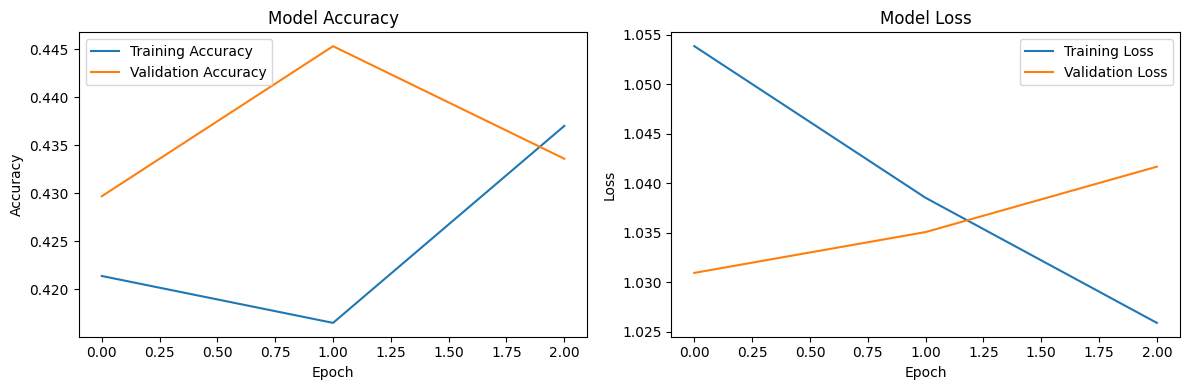

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold

# Assuming you have already preprocessed your data and have X_train, y_train_cat, etc.

# Load pre-trained GloVe embeddings
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

# Example: Load GloVe embeddings (ensure you have downloaded the file)
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

def build_model(max_words, max_len, embedding_dim, embedding_matrix, gru_units, dropout_rate, output_dim):
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
        Bidirectional(GRU(gru_units, return_sequences=True)),
        Bidirectional(GRU(gru_units)),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(output_dim, activation='softmax')
    ])
    return model

# Compile the model
def compile_model(model, learning_rate):
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# K-Fold Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store the results of each fold
val_accuracies = []
val_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}/{n_splits}")
    
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train_cat[train_idx], y_train_cat[val_idx]
    
    model = build_model(max_words, max_len, embedding_dim, embedding_matrix, gru_units=64, dropout_rate=0.5, output_dim=y_train_cat.shape[1])
    model = compile_model(model, learning_rate=0.001)
    
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=20,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr]
    )
    
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    
    print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print(f"\nAverage Validation Loss: {np.mean(val_losses):.4f}")
print(f"Average Validation Accuracy: {np.mean(val_accuracies):.4f}")

# Make predictions on the test set using the last trained model
predictions = model.predict(X_test)

# Optional: Visualize training history of the last fold
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
!pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.2/236.2 MB 38.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [33]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import tensorflow as tf

# Load the datasets
train = pd.read_json('Dataset/train.jsonl', lines=True)
test = pd.read_json('Dataset/test.jsonl', lines=True)
val = pd.read_json('Dataset/val.jsonl', lines=True)

# Text cleaning function
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(map(str, text))
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text

# Combine text fields
train['combined_text'] = train['postText'].astype(str) + ' ' + train['targetTitle'].astype(str) + ' ' + train['targetDescription'].astype(str)
test['combined_text'] = test['postText'].astype(str) + ' ' + test['targetTitle'].astype(str) + ' ' + test['targetDescription'].astype(str)
val['combined_text'] = val['postText'].astype(str) + ' ' + val['targetTitle'].astype(str) + ' ' + val['targetDescription'].astype(str)

# Clean text fields
train['combined_text'] = train['combined_text'].apply(clean_text)
test['combined_text'] = test['combined_text'].apply(clean_text)
val['combined_text'] = val['combined_text'].apply(clean_text)

# Prepare labels
def join_tags(tags):
    return ' '.join(sorted(tags)) if isinstance(tags, list) else tags

train['joined_tags'] = train['tags'].apply(join_tags)
val['joined_tags'] = val['tags'].apply(join_tags)

le = LabelEncoder()
train_labels = le.fit_transform(train['joined_tags'])
val_labels = le.transform(val['joined_tags'])

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences
MAX_LENGTH = 512

def encode_text(texts):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )

train_encodings = encode_text(train['combined_text'])
val_encodings = encode_text(val['combined_text'])
test_encodings = encode_text(test['combined_text'])

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [ ]:
from transformers import TFBertForSequenceClassification

# Load pre-trained BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset.shuffle(1000).batch(16),
    epochs=3,
    batch_size=16,
    validation_data=val_dataset.batch(16)
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_dataset.batch(16))
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Make predictions on the test set
test_predictions = model.predict(dict(test_encodings))
test_predictions = np.argmax(test_predictions.logits, axis=1)

# Convert predictions back to original labels
test_predictions_labels = le.inverse_transform(test_predictions)

# Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3796 - loss: 3.8098 - val_accuracy: 0.4266 - val_loss: 1.1015
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3916 - loss: 1.1456 - val_accuracy: 0.4266 - val_loss: 1.0852
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3772 - loss: 1.1032 - val_accuracy: 0.4047 - val_loss: 1.1036
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4053 - loss: 1.0831 - val_accuracy: 0.4031 - val_loss: 1.0789
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4022 - loss: 1.0657 - val_accuracy: 0.4266 - val_loss: 1.0751
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4228 - loss: 1.0605 - val_accuracy: 0.4266 - val_loss: 1.0806
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4330 - loss: 1.0519 - val_accuracy: 0.4266 - val_loss: 1.0676
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4064 - loss: 1.0546 - val_accuracy: 0.4250 - val_loss: 1.

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


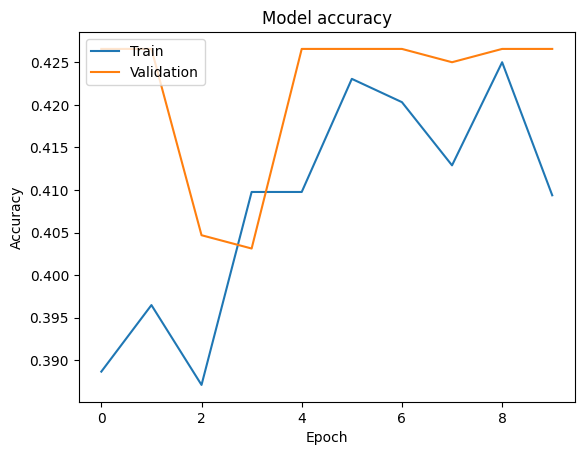

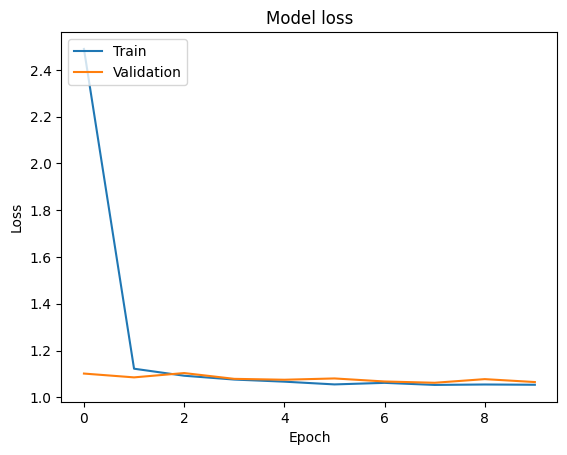

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build the model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_split.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
history = model.fit(X_train_split, y_train_split, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_val_split, y_val_split))
from sklearn.metrics import classification_report, accuracy_score

# Predict on the validation set
y_val_pred = model.predict(X_val_split)
y_val_pred_classes = y_val_pred.argmax(axis=1)  # Convert probabilities to class labels

# Print evaluation metrics
print("Validation Accuracy:", accuracy_score(y_val_split, y_val_pred_classes))
print("Validation Classification Report:")
print(classification_report(y_val_split, y_val_pred_classes))

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3003 - loss: 16.0422 - val_accuracy: 0.4156 - val_loss: 14.3172
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3873 - loss: 14.3503 - val_accuracy: 0.4172 - val_loss: 13.5330
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4335 - loss: 13.5005 - val_accuracy: 0.4359 - val_loss: 13.0140
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4755 - loss: 12.8016 - val_accuracy: 0.4391 - val_loss: 12.5707
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5595 - loss: 12.2708 - val_accuracy: 0.4531 - val_loss: 12.2002
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6062 - loss: 11.8064 - val_accuracy: 0.4625 - val_loss: 11.8613
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6603 - loss: 11.3524 - val_accuracy: 0.4672 - val_loss: 11.5178
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6996 - loss: 10.9815 - val_accuracy: 0.4750

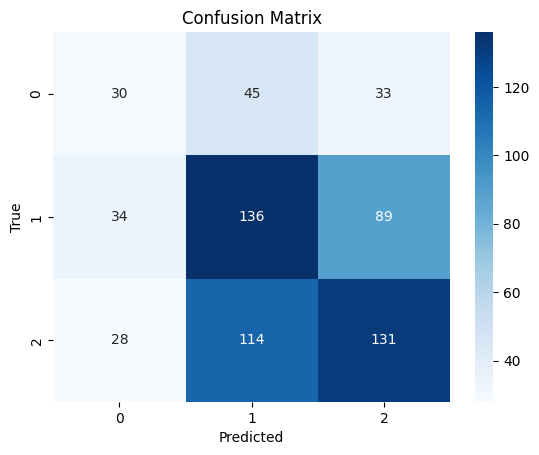

In [53]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Data preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)

# Label encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_split)
y_val_encoded = le.transform(y_val_split)

# Model
model = Sequential([
    Dense(512, kernel_regularizer=l2(0.01), input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(),
    Dropout(0.5),
    Dense(256, kernel_regularizer=l2(0.01)),
    LeakyReLU(),
    Dropout(0.5),
    Dense(128, kernel_regularizer=l2(0.01)),
    LeakyReLU(),
    Dense(len(le.classes_), activation='softmax')
])

# Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = dict(enumerate(class_weights))

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train model
history = model.fit(X_train_scaled, y_train_encoded,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_val_scaled, y_val_encoded),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_val_pred_prob = model.predict(X_val_scaled)
y_val_pred_classes = np.argmax(y_val_pred_prob, axis=1)

# Classification Report
print("Validation Classification Report:")
target_names = [str(cls) for cls in le.classes_]
print(classification_report(y_val_encoded, y_val_pred_classes, target_names=target_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_val_encoded, y_val_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [62]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from textblob import TextBlob
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# Load the datasets
train = pd.read_json('Dataset/train.jsonl', lines=True)
test = pd.read_json('Dataset/test.jsonl', lines=True)
val = pd.read_json('Dataset/val.jsonl', lines=True)

# Text cleaning function
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(map(str, text))
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text

# Sentiment analysis function
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Text augmentation function
def synonym_replacement(text):
    words = text.split()
    new_words = words.copy()
    for i in range(len(words)):
        synonyms = wordnet.synsets(words[i])
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words[i] = synonym
    return ' '.join(new_words)

# Preprocess and feature engineering
def preprocess_data(df):
    df['combined_text'] = df['postText'].astype(str) + ' ' + df['targetTitle'].astype(str) + ' ' + df['targetDescription'].astype(str)
    df['combined_text'] = df['combined_text'].apply(clean_text)
    df['text_length'] = df['combined_text'].str.len()
    df['sentiment'] = df['combined_text'].apply(get_sentiment)
    return df

# Apply preprocessing to all datasets
train = preprocess_data(train)
test = preprocess_data(test)
val = preprocess_data(val)

# Augment training data
train['augmented_text'] = train['combined_text'].apply(synonym_replacement)
train['combined_text'] = train['combined_text'] + ' ' + train['augmented_text']

# Tokenization and padding
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train['combined_text'])

def tokenize_and_pad(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_len)

X_train_text = tokenize_and_pad(train['combined_text'])
X_test_text = tokenize_and_pad(test['combined_text'])
X_val_text = tokenize_and_pad(val['combined_text'])

# One-hot encoding for categorical features
train_platform = pd.get_dummies(train['postPlatform'], prefix='platform')
test_platform = pd.get_dummies(test['postPlatform'], prefix='platform')
val_platform = pd.get_dummies(val['postPlatform'], prefix='platform')

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['text_length', 'sentiment']

X_train_numerical = scaler.fit_transform(train[numerical_features])
X_test_numerical = scaler.transform(test[numerical_features])
X_val_numerical = scaler.transform(val[numerical_features])

# Combine features
X_train_combined = np.concatenate([X_train_text, X_train_numerical, train_platform.values], axis=1)
X_test_combined = np.concatenate([X_test_text, X_test_numerical, test_platform.values], axis=1)
X_val_combined = np.concatenate([X_val_text, X_val_numerical, val_platform.values], axis=1)

# Prepare target variable
train['tags'] = train['tags'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)
val['tags'] = val['tags'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)

le = LabelEncoder()
y_train = le.fit_transform(train['tags'])
y_val = le.transform(val['tags'])

# Convert to categorical for multi-class classification
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Final split
X_train_split, X_val_split, y_train_split_cat, y_val_split_cat = train_test_split(X_train_combined, y_train_cat, test_size=0.2, random_state=42)

print("Final training set shape:", X_train_split.shape)
print("Final validation set shape:", X_val_split.shape)
print("Final test set shape:", X_test_combined.shape)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abiwaqasyasir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/abiwaqasyasir/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/abiwaqasyasir/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Final training set shape: (2560, 205)
Final validation set shape: (640, 205)
Final test set shape: (400, 205)
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 595ms/step - accuracy: 0.3393 - loss: 3.3916 - val_accuracy: 0.3359 - val_loss: 1.7349 - learning_rate: 0.0010
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 54s 672ms/step - accuracy: 0.4137 - loss: 1.4888 - val_accuracy: 0.3906 - val_loss: 1.2559 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 602ms/step - accuracy: 0.5474 - loss: 0.8588 - val_accuracy: 0.4250 - val_loss: 1.2464 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 628ms/step - accuracy: 0.5549 - loss: 0.6062 - val_accuracy: 0.3875 - val_loss: 1.3929 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 53s 658ms/step - accuracy: 0.5776 - loss: 0.5217 - val_accuracy: 0.4062 - val_loss: 1.3922 - learning_rate: 0.0010
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 58s 723ms/step - accuracy: 0.5782 - loss: 0.5243 - val_accuracy: 0.3891 - val_loss: 1.5

In [ ]:

# Define the model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model(max_words, max_len, num_classes, input_shape_numerical, input_shape_categorical):
    text_input = Input(shape=(max_len,), name='text_input')
    numerical_input = Input(shape=(input_shape_numerical,), name='numerical_input')
    categorical_input = Input(shape=(input_shape_categorical,), name='categorical_input')

    # Embedding and Bidirectional LSTM layers for text data
    embedding = Embedding(input_dim=max_words, output_dim=128)(text_input)
    bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)
    bi_lstm = Bidirectional(LSTM(128))(bi_lstm)

    # Dense layers for numerical data
    numerical_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(numerical_input)
    numerical_dense = Dropout(0.5)(numerical_dense)  # Added Dropout
    numerical_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(numerical_dense)

    # Dense layers for categorical data
    categorical_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(categorical_input)
    categorical_dense = Dropout(0.5)(categorical_dense)  # Added Dropout
    categorical_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(categorical_dense)

    # Concatenate all features
    concatenated = Concatenate()([bi_lstm, numerical_dense, categorical_dense])
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(concatenated)
    dropout = Dropout(0.5)(dense)
    output = Dense(num_classes, activation='softmax')(dropout)

    # Define the model
    model = Model(inputs=[text_input, numerical_input, categorical_input], outputs=output)
    return model

# Parameters
num_classes = y_train_cat.shape[1]
input_shape_numerical = X_train_numerical.shape[1]
input_shape_categorical = train_platform.shape[1]

# Create the model
model = create_model(max_words, max_len, num_classes, input_shape_numerical, input_shape_categorical)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(
    [X_train_split[:, :max_len], X_train_split[:, max_len:max_len+input_shape_numerical], X_train_split[:, max_len+input_shape_numerical:]],
    y_train_split_cat,
    epochs=50,
    batch_size=32,
    validation_data=([X_val_split[:, :max_len], X_val_split[:, max_len:max_len+input_shape_numerical], X_val_split[:, max_len+input_shape_numerical:]], y_val_split_cat),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate([X_val_split[:, :max_len], X_val_split[:, max_len:max_len+input_shape_numerical], X_val_split[:, max_len+input_shape_numerical:]], y_val_split_cat)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Predictions
y_val_pred = model.predict([X_val_split[:, :max_len], X_val_split[:, max_len:max_len+input_shape_numerical], X_val_split[:, max_len+input_shape_numerical:]])
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("Validation Classification Report:")
print(classification_report(np.argmax(y_val_split_cat, axis=1), y_val_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(np.argmax(y_val_split_cat, axis=1), y_val_pred_classes))


In [110]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Bidirectional, LSTM


# Define the input layers
text_input = tf.keras.Input(shape=(200,), name='text_input')
numerical_input = tf.keras.Input(shape=(2,), name='numerical_input')
categorical_input = tf.keras.Input(shape=(3,), name='categorical_input')

# Text processing
embedding_layer = tf.keras.layers.Embedding(input_dim=10000, output_dim=128)(text_input)
conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
conv2 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(pool2)
dropout_lstm = tf.keras.layers.Dropout(0.5)(lstm_layer)

# Additional features processing
dense_numerical = tf.keras.layers.Dense(64, activation='relu')(numerical_input)
dense_categorical = tf.keras.layers.Dense(64, activation='relu')(categorical_input)
dropout_numerical = tf.keras.layers.Dropout(0.5)(dense_numerical)
dropout_categorical = tf.keras.layers.Dropout(0.5)(dense_categorical)

# Concatenate all features
concat = tf.keras.layers.Concatenate()([dropout_lstm, dropout_numerical, dropout_categorical])

# Dense layers and output
dense1 = tf.keras.layers.Dense(128, activation='relu')(concat)
dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(3, activation='softmax')(dropout1)

# Create and compile the model
model = tf.keras.Model(inputs=[text_input, numerical_input, categorical_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional_98"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_89        │ (None, 200, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 196, 128)  │     82,048 │ embedding_89[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 98, 128)   │          0 │ conv1d_25[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 94, 128)   │     82,048 │ max_pooling1d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_26    │ (None, 47, 128)   │          0 │ conv1d_26[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_82    │ (None, 256)       │    263,168 │ max_pooling1d_26… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_251 (Dense)   │ (None, 64)        │        192 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_252 (Dense)   │ (None, 64)        │        256 │ categorical_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_154         │ (None, 256)       │          0 │ bidirectional_82… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_155         │ (None, 64)        │          0 │ dense_251[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_156         │ (None, 64)        │          0 │ dense_252[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 384)       │          0 │ dropout_154[0][0… │
│ (Concatenate)       │                   │            │ dropout_155[0][0… │
│                     │                   │            │ dropout_156[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_253 (Dense)   │ (None, 128)       │     49,280 │ concatenate_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_157         │ (None, 128)       │          0 │ dense_253[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_254 (Dense)   │ (None, 3)         │        387 │ dropout_157[0][0] │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 1,757,379 (6.70 MB)

 Trainable params: 1,757,379 (6.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

# Cross-validation loop
for fold_no, (train_index, val_index) in enumerate(kf.split(X[0]), 1):
    # Split data for this fold
    X_train = [X[i][train_index] for i in range(len(X))]
    X_val = [X[i][val_index] for i in range(len(X))]
    y_train = y[train_index]
    y_val = y[val_index]
    
    # Initialize model
    model = create_model(max_words=10000, max_len=200, num_classes=3, 
                         input_shape_numerical=(2,), input_shape_categorical=(3,))
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=1e-5)
    
    # Check if labels are one-hot encoded or integer indices
    is_one_hot = y_train.ndim > 1
    loss_function = 'categorical_crossentropy' if is_one_hot else 'sparse_categorical_crossentropy'
    
    # Compile the model
    model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict,
        callbacks=[early_stopping, reduce_lr]
    )
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Fold {fold_no} - Validation Loss: {val_loss}")
    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy}")
    
    # Calculate and store F1 Score
    y_val_pred = model.predict(X_val)
    f1_score = calculate_f1_score(y_val, y_val_pred)  # Ensure you have this function
    f1_scores.append(f1_score)
    print(f"Fold {fold_no} - F1 Score: {f1_score}")

# Average F1 Score
average_f1_score = np.mean(f1_scores)
print(f"Average F1 Score across {kf.get_n_splits()} folds: {average_f1_score}")


In [117]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Generate predictions
y_pred = model.predict([X_val_text, X_val_numerical, val_platform.values])
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate F1 score
y_true_classes = np.argmax(y_val_cat, axis=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print classification report and confusion matrix
print("Validation F1 Score (weighted):", f1)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Validation F1 Score (weighted): 0.44279014356109864
Classification Report:
              precision    recall  f1-score   support

       multi       0.50      0.31      0.38        84
     passage       0.44      0.80      0.57       154
      phrase       0.59      0.25      0.35       162

    accuracy                           0.47       400
   macro avg       0.51      0.45      0.44       400
weighted avg       0.52      0.47      0.44       400

Confusion Matrix:
[[ 26  49   9]
 [ 12 123  19]
 [ 14 107  41]]


In [77]:
# Generate predictions
y_pred = model.predict([X_test_text, X_test_numerical, test_platform.values])
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert predictions back to original labels
y_pred_labels = le.inverse_transform(y_pred_classes)

# Save predictions to a CSV file
submission = pd.DataFrame({'id': test['id'], 'spoilerType': y_pred_labels})
submission.to_csv('submission1.csv', index=False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
